# 프로젝트 : 주식 예측에 도전해보기

#### ✔️ Dataset :
>**[Yahoo Finance](https://finance.yahoo.com)** → 기업 검색 → Historical Data 탭 → Download

#### ✔️ 모듈 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import os
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose  # 시계열 분리 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # ACF, PACF 그래프
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

import warnings
warnings.filterwarnings('ignore')

---

## Step 1. 시계열 데이터 준비

대한민국 대장주 삼성전자에 대한 주식 시세부터 예측해보자.
<br> (일단 기존에 주어진 데이터 : 2020년 5월 18일 ~ 2021년 5월 18일까지 1년의 데이터)
- 칼럼 종류 : Date, Open, High, Low, Close, Adj Close, Volume
- 날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있다.
- 우리는 종가(Close)만 사용할 예정이다. (하루의 장이 마감하였을 때의 가격)

In [2]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

---
## Step 2. 각종 전처리 수행
### 1) 시계열 데이터 시각화

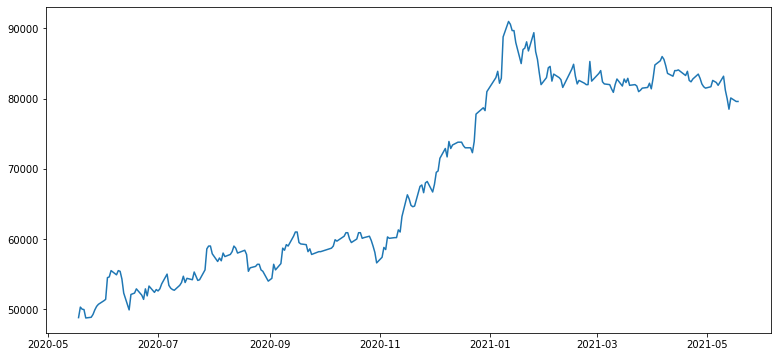

In [3]:
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정

plt.plot(ts)

### 2) 결측치 처리

In [4]:
ts[ts.isna()]  # 결측치 확인

Series([], Name: Close, dtype: float64)

In [5]:
ts = ts.interpolate(method='time') # 결측치 보간(interpolate)하여 대입
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력

Series([], Name: Close, dtype: float64)

### 2) 로그 변환

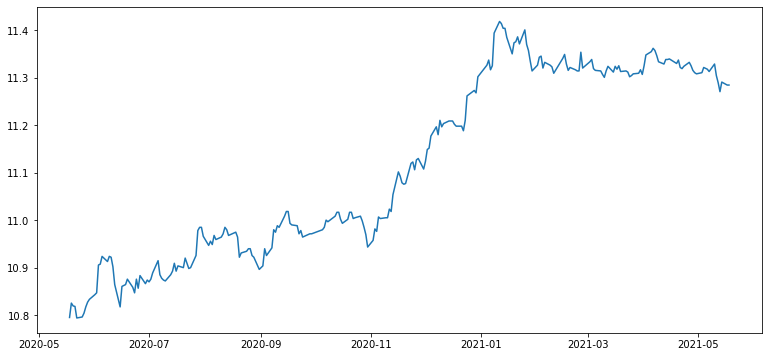

In [6]:
ts_log = np.log(ts)

# 로그 변환해준 후 다시 데이터 시각화
plt.plot(ts_log)

---
## Step 3. 시계열 안정성 분석
### 1) 정성적 그래프 분석

일정 시간 내 구간 통계치(Rolling Statistics)를 시각화해 보는 함수를 만들어보자.
<br> 현재 타임 스텝부터 window에 주어진 타임 스텝 이전 사이의
1. 구간의 평균(rolling mean, 이동평균)
2. 표준편차 (rolling std, 이동표준편차)

를 원본 시계열과 함께 시각화해준다.

In [7]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

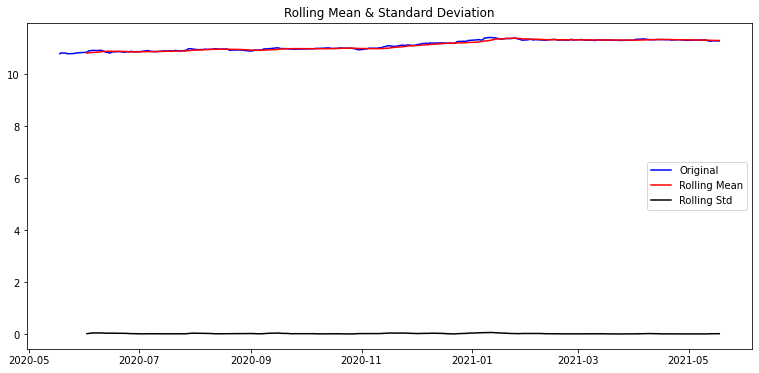

In [8]:
plot_rolling_statistics(ts_log, window=12)

### 2) 정량적 Augmented Dicky-Fuller Test

statsmodels 패키지에서 제공하는 adfuller 메서드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 함수를 만들어보고 수행해보자.

In [9]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [10]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


p-value가 꽤 높다.

### 3) 시계열 분해(Time Series Decomposition)

statsmodels 라이브러리 안에는 seasonal_decompose 메서드를 통해 시계열 안에 존재하는 trend, seasonality를 직접 분리해 낼 수 있는 기능이 있다. 이 기능을 활용하면 moving average 제거, differencing 등을 거치지 않고도 훨씬 안정적인 시계열을 분리해 낼 수 있게 된다.

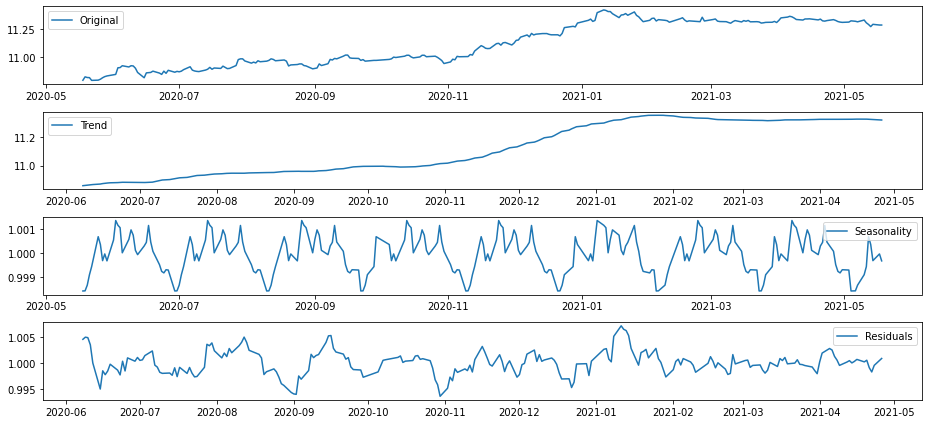

In [11]:
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid   # Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### 4) Residual 안정성 확인

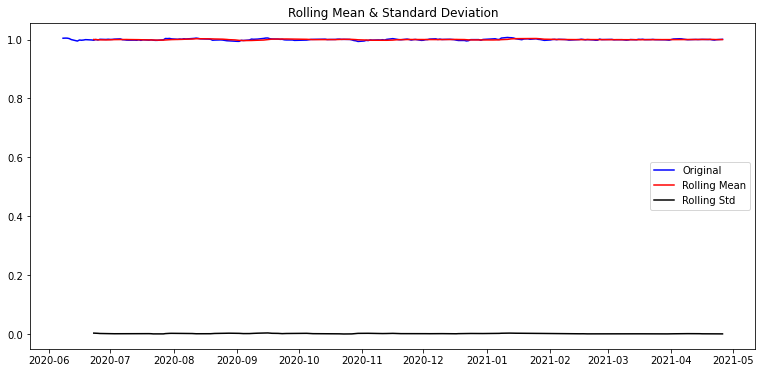

In [12]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [13]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -6.187586e+00
p-value                        6.234854e-08
#Lags Used                     9.000000e+00
Number of Observations Used    2.100000e+02
Critical Value (1%)           -3.461879e+00
Critical Value (5%)           -2.875404e+00
Critical Value (10%)          -2.574159e+00
dtype: float64


Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보여준다. 이 정도면 확실히 예측 가능한 수준의 안정적인 시계열이 얻어졌다고 볼 수 있다.

---
## Step 4. 학습, 테스트 데이터셋 생성
### 학습, 테스트 데이터셋 분리

시계열 예측이니 가장 나중 데이터를 테스트용으로 사용하는 것이 타당하다.

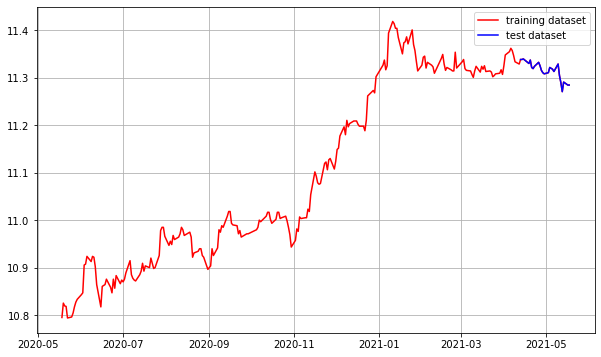

In [14]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

데이터셋의 형태 확인

In [15]:
print(train_data.shape)
print(test_data.shape)

(225,)
(25,)


---
## Step 5. 적정 ARIMA 모수 찾기

ARIMA의 3가지 모수
- p : 자기회귀 모형(AR)의 시차
- d : 차분 누적(I) 횟수
- q : 이동평균 모형(MA)의 시차

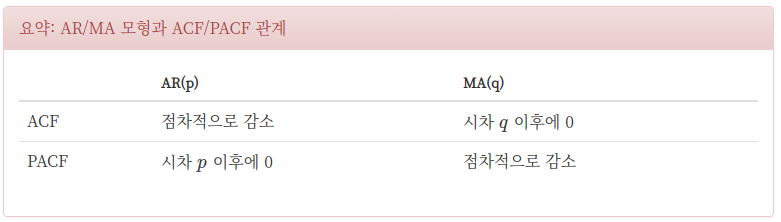

### 1) ACF, PACF 그려보기 → p, q 구하기

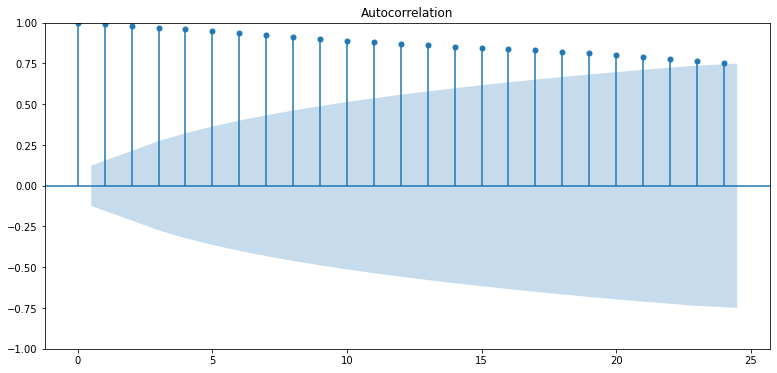

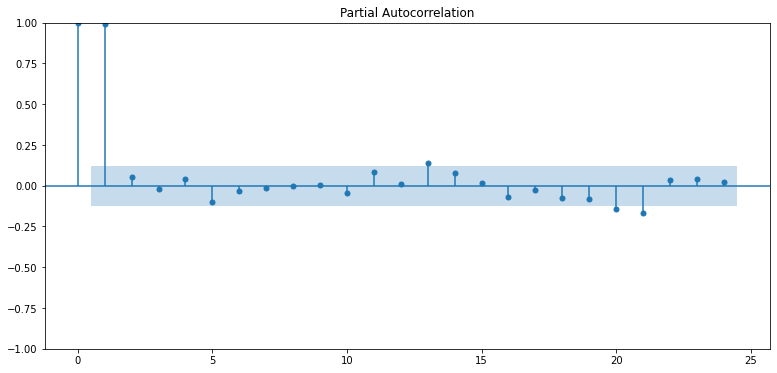

In [16]:
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

ACF는 점차적으로 감소하고 있고, PACF는 시차 1 이후에 0이 된다. AR(1) 모델에 유사한 형태를 보이는 것으로 보이고, MA는 고려할 필요가 없으므로 p=1, q=0으로 둬도 될 것 같다.

### 2) 차분 안정성 확인 → d 구하기

먼저 1차 차분 구하고 시계열이 안정된 상태인지 확인해보자.

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64


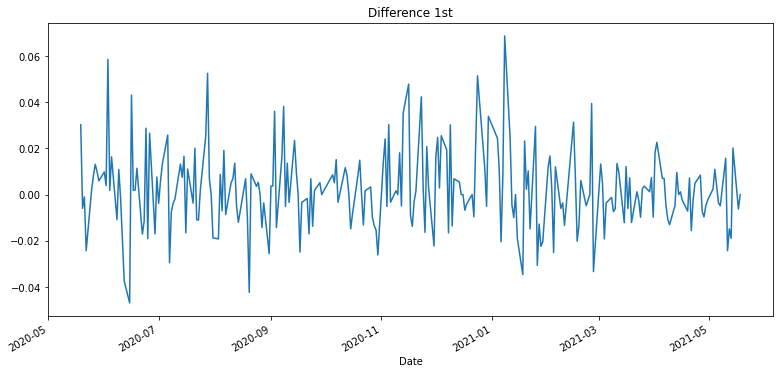

In [17]:
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

1차 차분만 해줘도 p-value가 굉장히 낮기 때문에 d=1로 두고 시작해도 될 것 같다.

---

## Step 6. ARIMA 모델 훈련과 테스트

### 1) ARIMA 모델 빌드와 훈련

In [18]:
model = ARIMA(train_data, order=(1, 1, 0))   # p=1, d=1, q=0
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 583.488
Date:                Thu, 17 Feb 2022   AIC                          -1162.976
Time:                        14:22:01   BIC                          -1156.153
Sample:                             0   HQIC                         -1160.222
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0333      0.061      0.545      0.586      -0.086       0.153
sigma2         0.0003   2.42e-05     13.219      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.06   Jarque-

ARIMA 모델의 훈련 결과를 시각적으로 확인해보자.

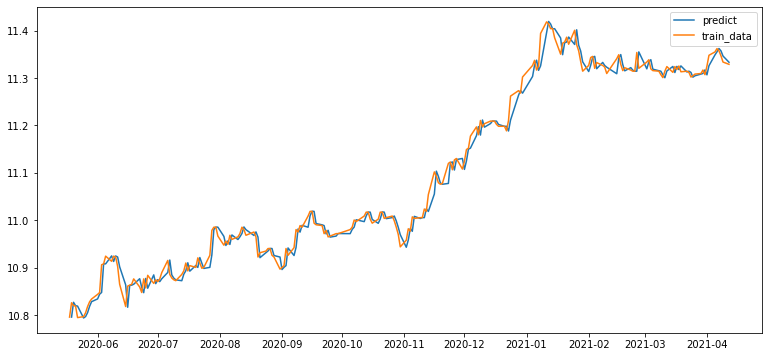

In [19]:
fitted_m = fitted_m.predict()
fitted_m = fitted_m.drop(fitted_m.index[0])
plt.plot(fitted_m, label='predict')
plt.plot(train_data, label='train_data')
plt.legend()

### 2) 모델 테스트 및 플로팅

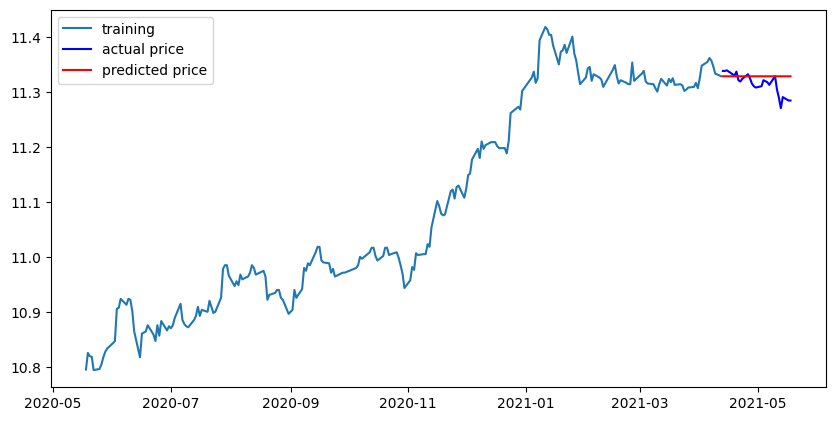

In [20]:
# Forecast : 결과가 fc에 담김
model = ARIMA(train_data, order=(1, 1, 0))   # p=1, d=1, q=0
fitted_m = model.fit() 
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

### 3) 최종 예측 모델 정확도 측정(MAPE)

시계열 데이터를 로그 변환하여 사용했으므로 다시 지수 변환해야 정확한 오차를 계산할 수 있다. <br>np.exp()를 통해 전부 원본 스케일로 돌린 후 MSE, MAE, RMSE, MAPE를 계산해보자.

In [21]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  3480513.747715865
MAE:  1403.033723618997
RMSE:  1865.6135043775453
MAPE: 1.74%


그래프 상에서는 예측을 제대로 잘하지 못했는데 MAPE가 낮게 나온 이유는 어느 정도 마지막 예측값이 비슷해서 그런 듯 싶다. ARIMA의 모수들을 제대로 뽑아내지 못한 것 같아서 LMS 본문의 예시에 있던 p=2, d=0, q=1을 사용해서 다시 해보겠다.

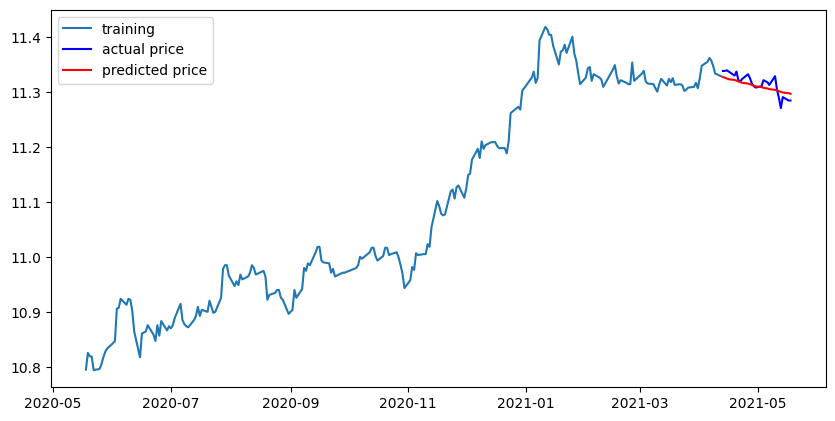

In [22]:
model = ARIMA(train_data, order=(2, 0, 1))   # p=2, d=0, q=1
fitted_m = model.fit() 

# Forecast : 결과가 fc에 담김
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [23]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1048973.6014239907
MAE:  843.7579531508708
RMSE:  1024.19412292006
MAPE: 1.03%


이렇게 하니깐 방향은 얼추 맞고 MAPE도 더 낮게 나왔는데, 도대체 어떤 기준으로 모수들을 정하는건지 모르겠다. 나는 가르쳐준대로 파악하고 1, 1, 0을 지정한건데 이상하다.

---

## Step 7. 다른 주식 종목 예측해보기

1년 치의 데이터셋은 코로나 때문에 변동성이 심했던 것 같아서, 기간을 5년으로 늘려보기로 했다.
<br>기간 : 2017년 2월 17일 ~ 2022년 2월 17일
<br>종목 : 구글, 아마존, 카카오

### **1. [Alphabet Inc. (Google)](https://finance.yahoo.com/quote/GOOG/history?period1=1487289600&period2=1645056000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true)**

#### 1) 데이터 준비

In [24]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/GOOG.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2017-02-17    828.070007
2017-02-21    831.659973
2017-02-22    830.760010
2017-02-23    831.330017
2017-02-24    828.640015
Name: Close, dtype: float64

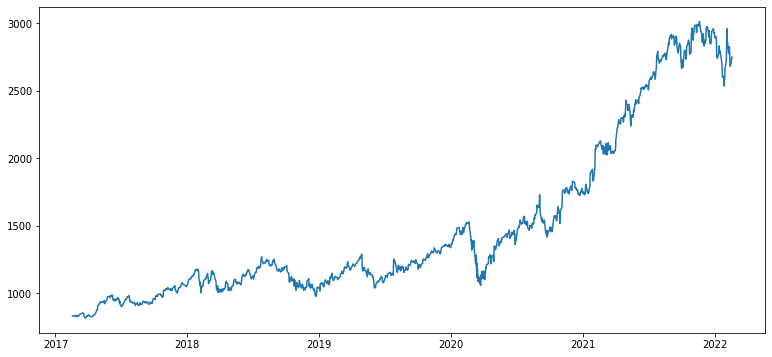

In [25]:
# 데이터 시각화
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정

plt.plot(ts)

#### 2) 각종 전처리 수행

In [26]:
# 결측치 확인
ts[ts.isna()]  

Series([], Name: Close, dtype: float64)

In [27]:
# 로그 변환
ts_log = np.log(ts)

#### 3) 시계열 안정성 분석

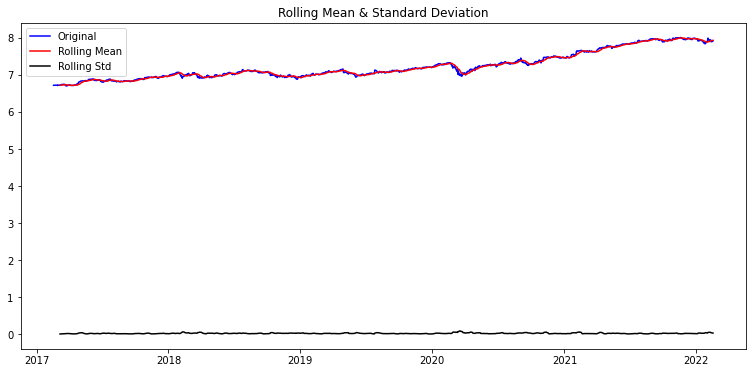

In [28]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [29]:
# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -0.091902
p-value                           0.950239
#Lags Used                       22.000000
Number of Observations Used    1236.000000
Critical Value (1%)              -3.435652
Critical Value (5%)              -2.863881
Critical Value (10%)             -2.568016
dtype: float64


p-value가 1에 상당히 가깝다.

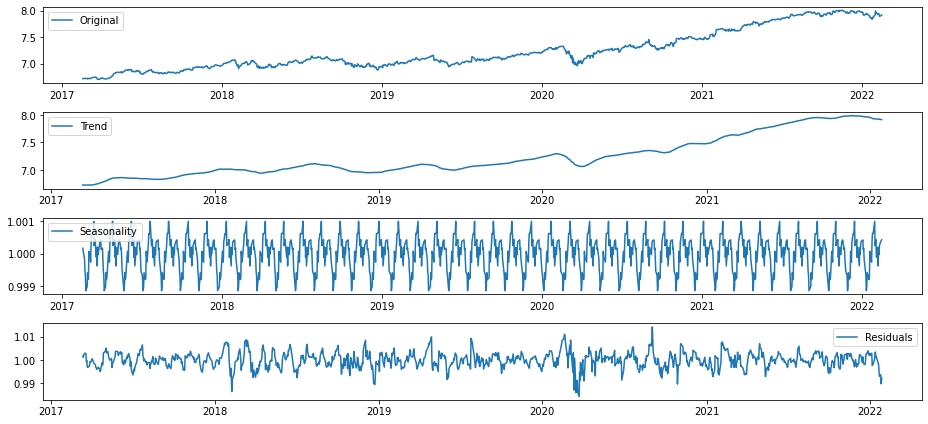

In [30]:
# 시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid   # Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

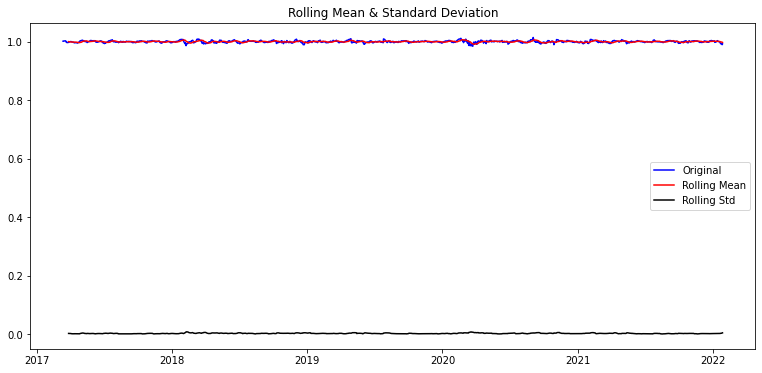

In [31]:
# Residual 안정성 확인
plot_rolling_statistics(residual)

In [32]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.045877e+01
p-value                        1.376483e-18
#Lags Used                     1.800000e+01
Number of Observations Used    1.210000e+03
Critical Value (1%)           -3.435766e+00
Critical Value (5%)           -2.863932e+00
Critical Value (10%)          -2.568043e+00
dtype: float64


Residual의 p-value는 역시 상당히 낮다.

#### 4)  학습, 테스트 데이터셋 생성

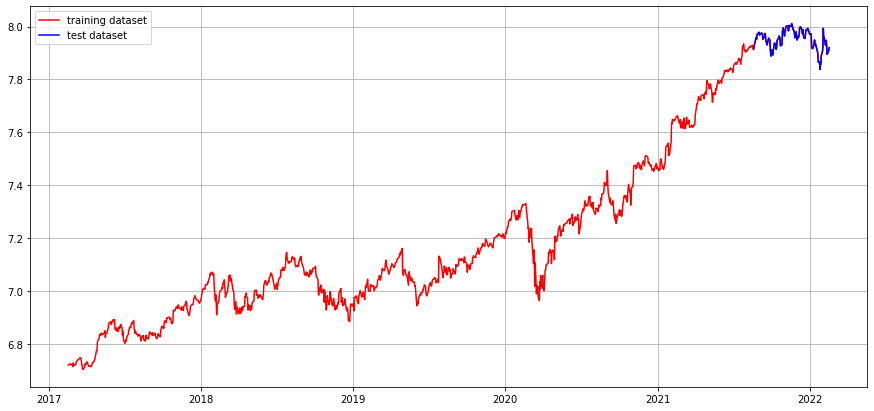

In [33]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(15,7))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [34]:
print(train_data.shape)
print(test_data.shape)

(1133,)
(126,)


#### 5) 적정 ARIMA 모수 찾기

<Figure size 720x432 with 0 Axes>

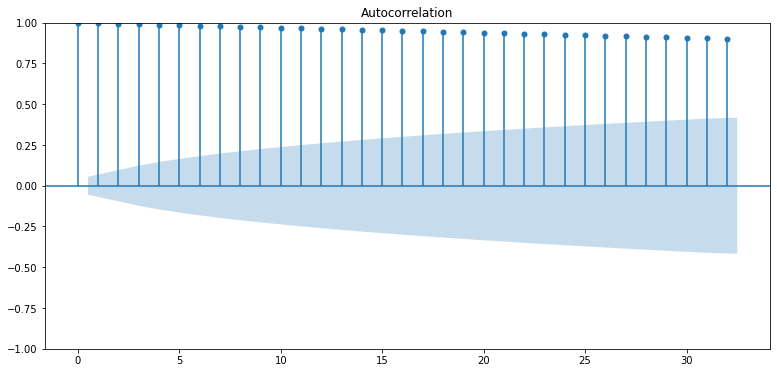

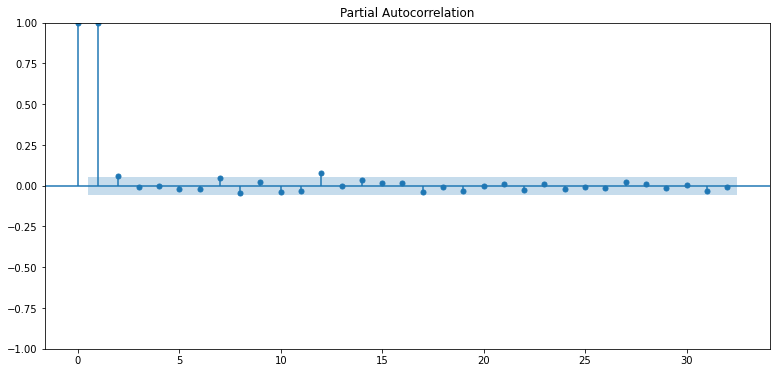

In [35]:
# ACF, PACF 그려보기 -> p,q 구하기
plt.figure(figsize=(10,6))
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

앞서 삼성전자 주식과 마찬가지로 ACF는 아주 조금씩 감소하고 있고, PACF는 시차 1 이후에 0이 된다. <br>구글 주식 역시 AR(1) 모델에 유사한 형태를 보이는 것 같고, MA랑은 맞지 않으므로 p=1, q=0으로 지정해야겠다.

Results of Dickey-Fuller Test:
Test Statistic                -8.229948e+00
p-value                        6.101065e-13
#Lags Used                     2.100000e+01
Number of Observations Used    1.236000e+03
Critical Value (1%)           -3.435652e+00
Critical Value (5%)           -2.863881e+00
Critical Value (10%)          -2.568016e+00
dtype: float64


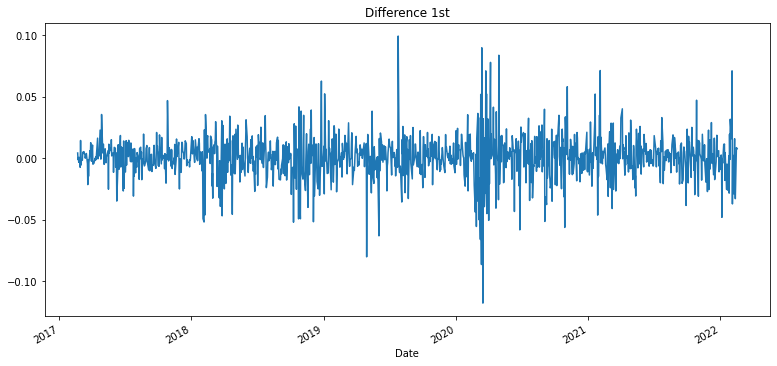

In [36]:
# 차분 안정성 확인
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

1차 차분만 했을 때도 굉장히 안정된 형태이다. d=1로 지정해준다.

#### 6) ARIMA 모델 훈련과 테스트

In [37]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(1, 1, 0))   # p=1, d=1, q=0
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1133
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2986.650
Date:                Thu, 17 Feb 2022   AIC                          -5969.299
Time:                        14:22:04   BIC                          -5959.236
Sample:                             0   HQIC                         -5965.498
                               - 1133                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1332      0.018     -7.415      0.000      -0.168      -0.098
sigma2         0.0003   6.81e-06     43.930      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.02   Jarque-

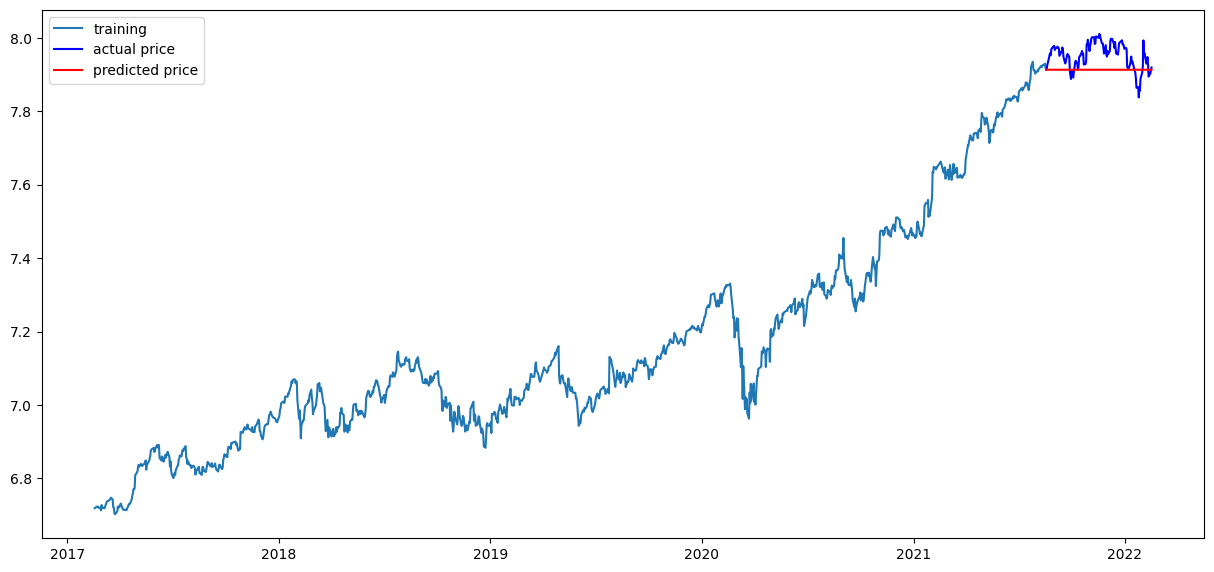

In [38]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담김
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(15,7), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [39]:
# 최종 예측 모델 정확도 측정(MAPE)
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  22051.89124143828
MAE:  127.71412902788313
RMSE:  148.49879205380185
MAPE: 4.43%


ARIMA의 모수 결정을 또 실패했나보다. 아까 썼던 p=2, d=0, q=1을 다시 지정해서 모델을 돌려봐야겠다.

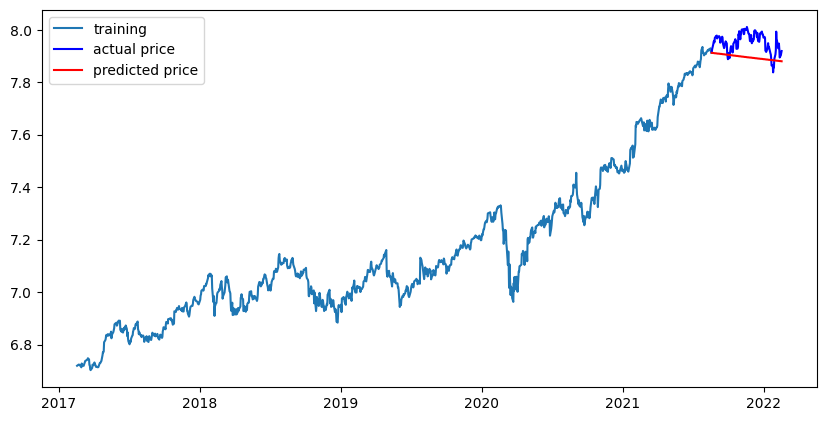

In [40]:
model = ARIMA(train_data, order=(2, 0, 1))   # p=2, d=0, q=1
fitted_m = model.fit() 

# Forecast : 결과가 fc에 담김
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [41]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  33786.50685974333
MAE:  162.11865240069366
RMSE:  183.8110629416612
MAPE: 5.61%


---

### 2. **[Amazon.com, INC](https://finance.yahoo.com/quote/AMZN/history?period1=1487289600&period2=1645056000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true)**

#### 1) 데이터 준비

In [42]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AMZN.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2017-02-17    845.070007
2017-02-21    856.440002
2017-02-22    855.609985
2017-02-23    852.190002
2017-02-24    845.239990
Name: Close, dtype: float64

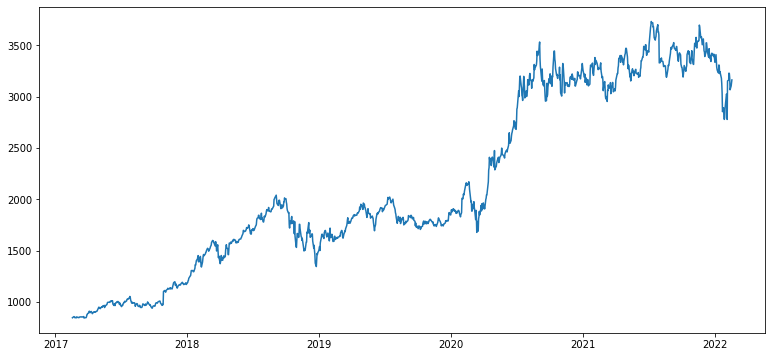

In [43]:
# 데이터 시각화
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정

plt.plot(ts)

#### 2) 각종 전처리 수행

In [44]:
# 결측치 확인
ts[ts.isna()]  

Series([], Name: Close, dtype: float64)

In [45]:
# 로그 변환
ts_log = np.log(ts)

#### 3) 시계열 안정성 분석

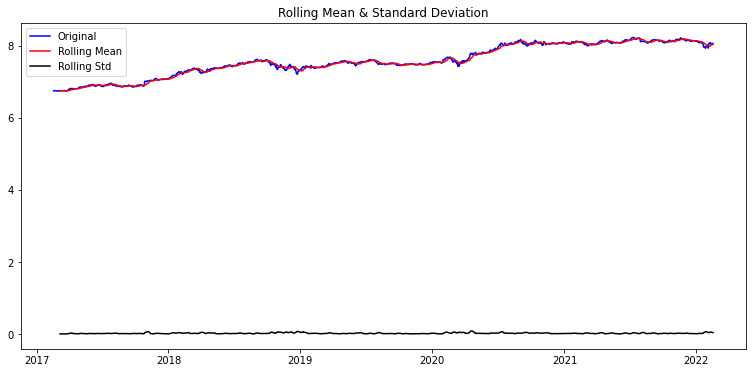

In [46]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [47]:
# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -1.684998
p-value                           0.438858
#Lags Used                       10.000000
Number of Observations Used    1248.000000
Critical Value (1%)              -3.435601
Critical Value (5%)              -2.863859
Critical Value (10%)             -2.568004
dtype: float64


p-value는 0.43이다.

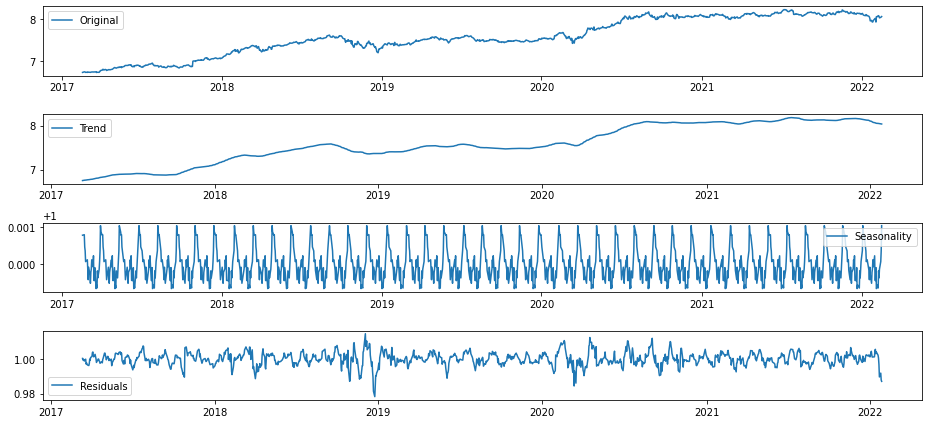

In [48]:
# 시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid   # Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

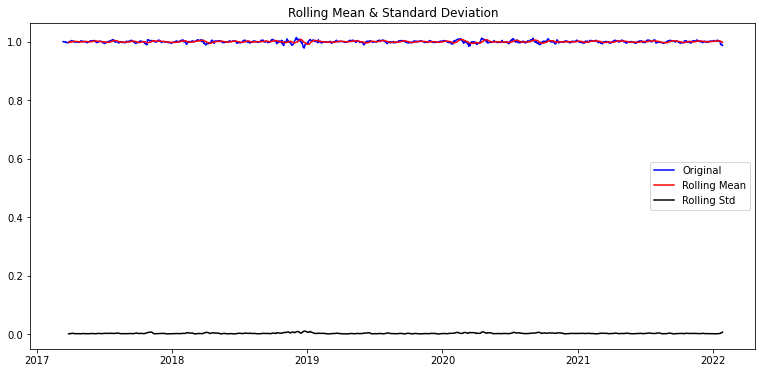

In [49]:
# Residual 안정성 확인
plot_rolling_statistics(residual)

In [50]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.088697e+01
p-value                        1.252819e-19
#Lags Used                     2.300000e+01
Number of Observations Used    1.205000e+03
Critical Value (1%)           -3.435788e+00
Critical Value (5%)           -2.863942e+00
Critical Value (10%)          -2.568049e+00
dtype: float64


#### 4)  학습, 테스트 데이터셋 생성

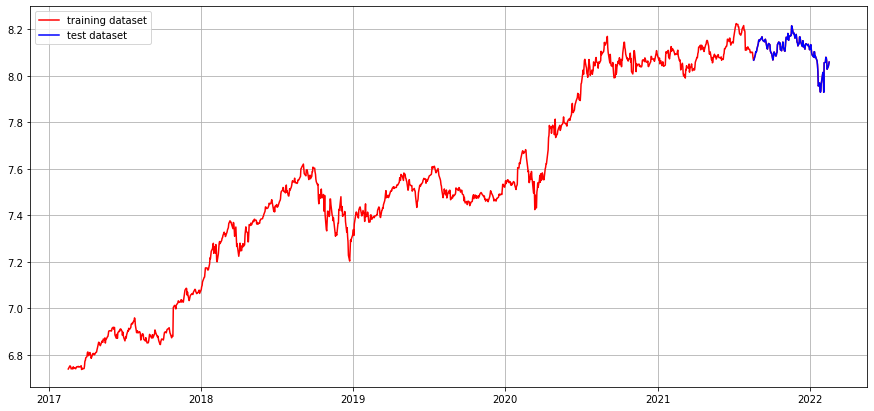

In [51]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(15,7))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [52]:
print(train_data.shape)
print(test_data.shape)

(1133,)
(126,)


#### 5) 적정 ARIMA 모수 찾기

<Figure size 720x432 with 0 Axes>

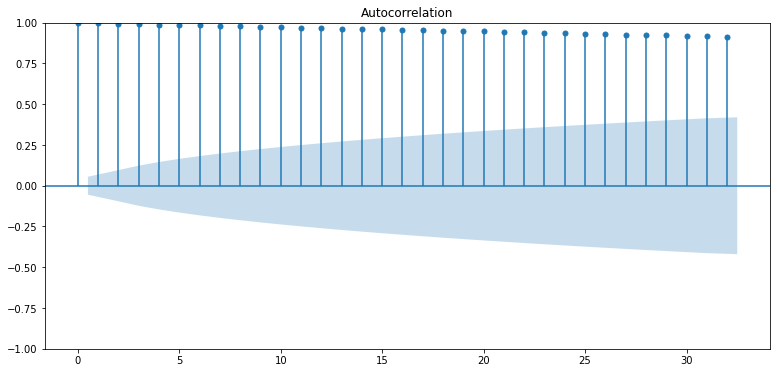

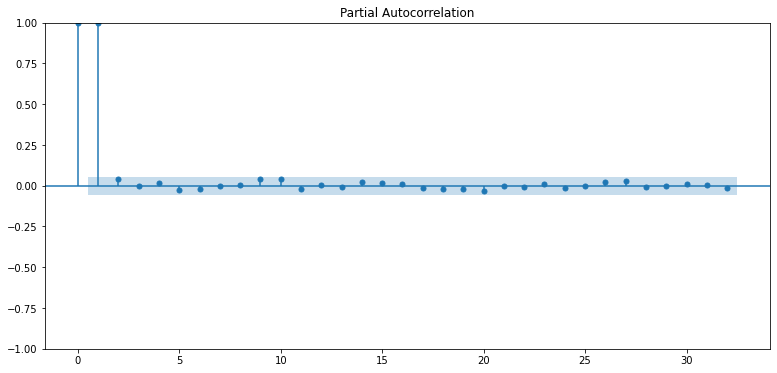

In [53]:
# ACF, PACF 그려보기 -> p,q 구하기
plt.figure(figsize=(10,6))
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

구글 주식과 형태가 거의 유사하다. 뭔가 빠뜨려서 구글 주식의 ACF와 PACF를 가져온 줄 착각했다. ACF는 아주 조금씩 감소하고 있고, PACF는 시차 1 이후에 0이 되므로 역시 AR(1) 모델에 유사하고 MA랑은 맞지 않으므로 p=1, q=0으로 지정해준다.

Results of Dickey-Fuller Test:
Test Statistic                -1.205870e+01
p-value                        2.498406e-22
#Lags Used                     9.000000e+00
Number of Observations Used    1.248000e+03
Critical Value (1%)           -3.435601e+00
Critical Value (5%)           -2.863859e+00
Critical Value (10%)          -2.568004e+00
dtype: float64


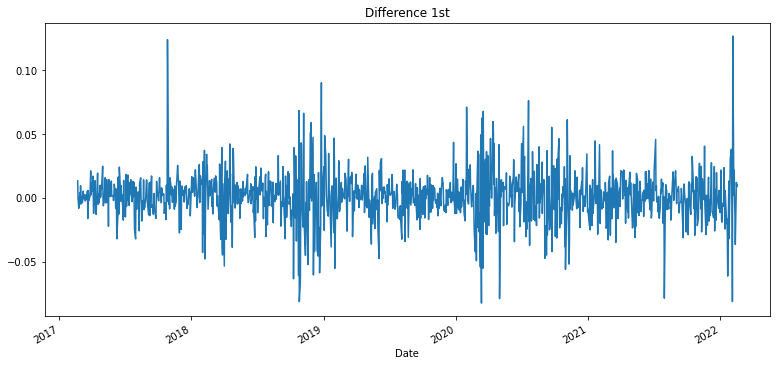

In [54]:
# 차분 안정성 확인
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

마찬가지로 d=1을 지정해준다.

#### 6) ARIMA 모델 훈련과 테스트

In [55]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(1, 1, 0))   # p=1, d=1, q=0
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1133
Model:                 ARIMA(1, 1, 0)   Log Likelihood                2882.709
Date:                Thu, 17 Feb 2022   AIC                          -5761.417
Time:                        14:22:08   BIC                          -5751.354
Sample:                             0   HQIC                         -5757.615
                               - 1133                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0499      0.021     -2.423      0.015      -0.090      -0.010
sigma2         0.0004   8.61e-06     41.730      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.02   Jarque-

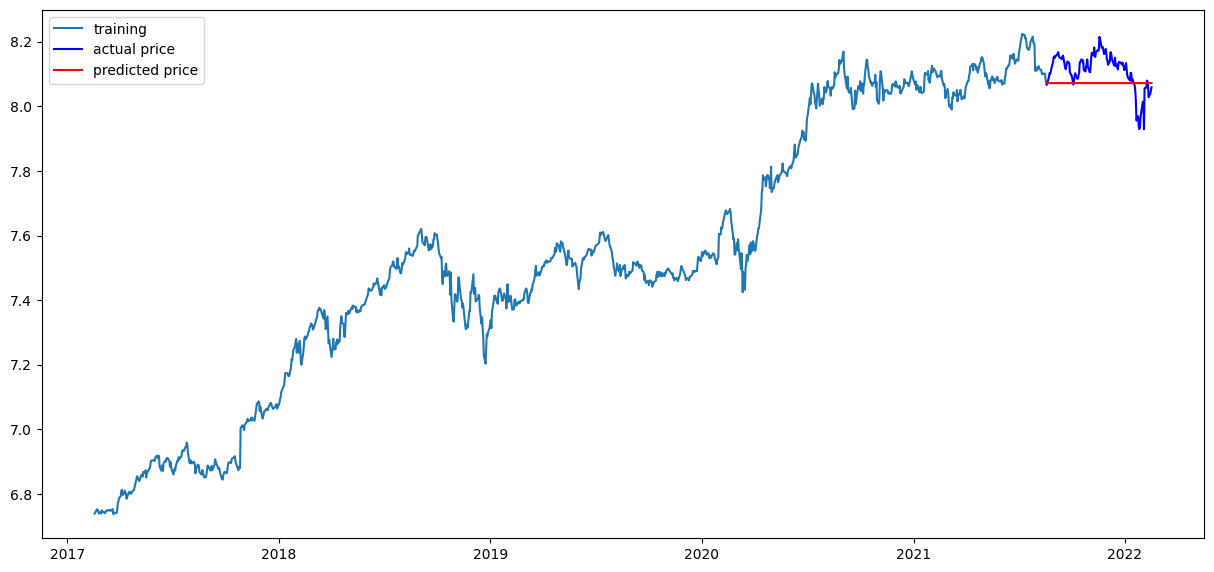

In [56]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담김
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(15,7), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [57]:
# 최종 예측 모델 정확도 측정(MAPE)
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  51201.57182325568
MAE:  195.89120034259216
RMSE:  226.27764322454766
MAPE: 5.85%


마찬가지다.. 다시 모수 변경해서 넣어보겠다.

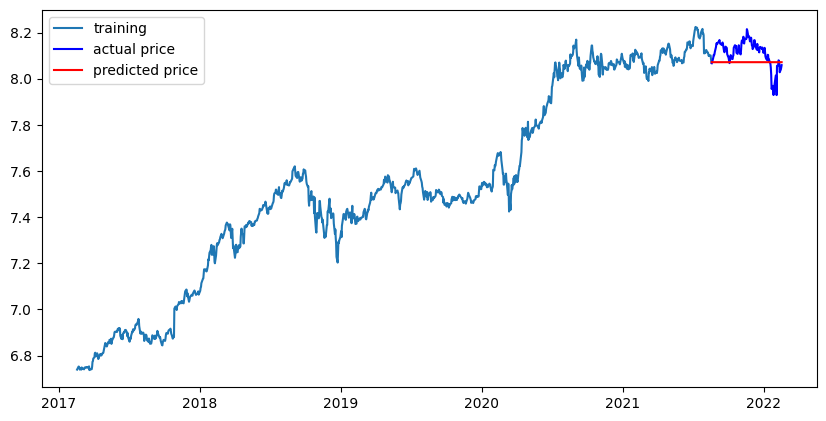

In [58]:
model = ARIMA(train_data, order=(2, 1, 1))   # p=2, d=1, q=1
fitted_m = model.fit() 

# Forecast : 결과가 fc에 담김
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [59]:
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  51280.18806267854
MAE:  196.08041642526638
RMSE:  226.45129291456595
MAPE: 5.85%


자꾸 평평한 일직선을 그리는 것이 화가 나서 최근 주가가 하향세를 그렸던 카카오를 대신 끼워넣어봤다.

### 3. **[Kakao Corp.](https://finance.yahoo.com/quote/035720.KS/history?period1=1487289600&period2=1645056000&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true)**

#### 1) 데이터 준비

In [60]:
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/035720.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
2017-02-17    16940.0
2017-02-20    16960.0
2017-02-21    17680.0
2017-02-22    17900.0
2017-02-23    17580.0
Name: Close, dtype: float64

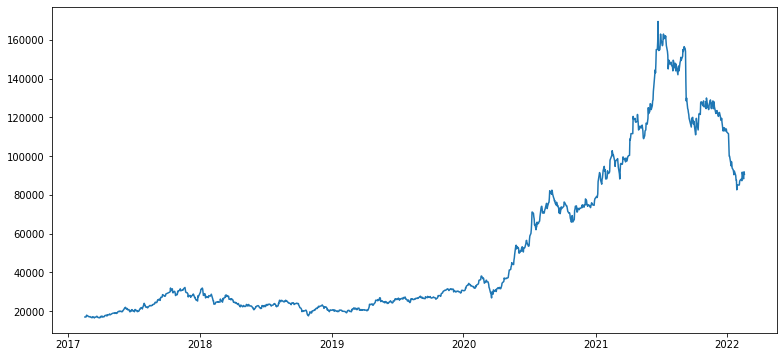

In [61]:
# 데이터 시각화
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정

plt.plot(ts)

#### 2) 각종 전처리 수행

In [62]:
# 결측치 확인
ts[ts.isna()]  

Series([], Name: Close, dtype: float64)

In [63]:
# 로그 변환
ts_log = np.log(ts)

#### 3) 시계열 안정성 분석

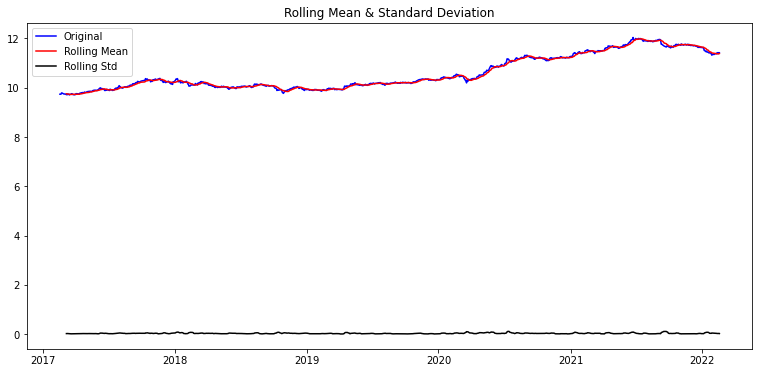

In [64]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

In [65]:
# 정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -0.612471
p-value                           0.868139
#Lags Used                        2.000000
Number of Observations Used    1222.000000
Critical Value (1%)              -3.435713
Critical Value (5%)              -2.863908
Critical Value (10%)             -2.568031
dtype: float64


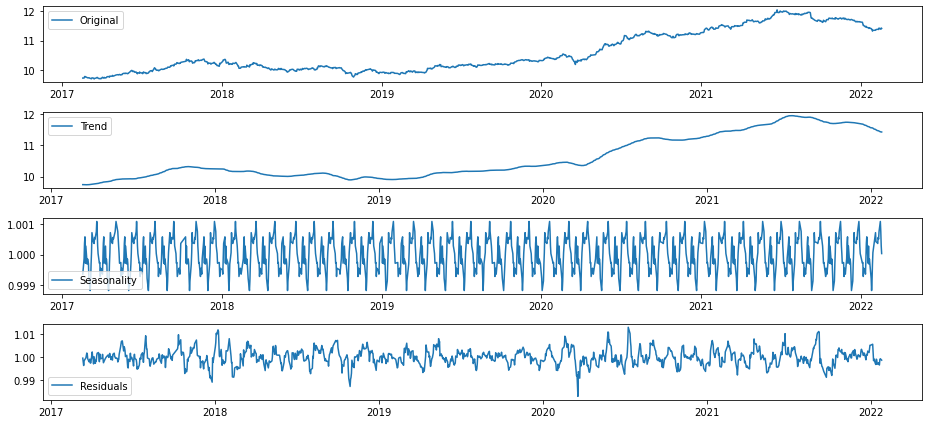

In [66]:
# 시계열 분해 (Time Series Decomposition)
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid   # Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

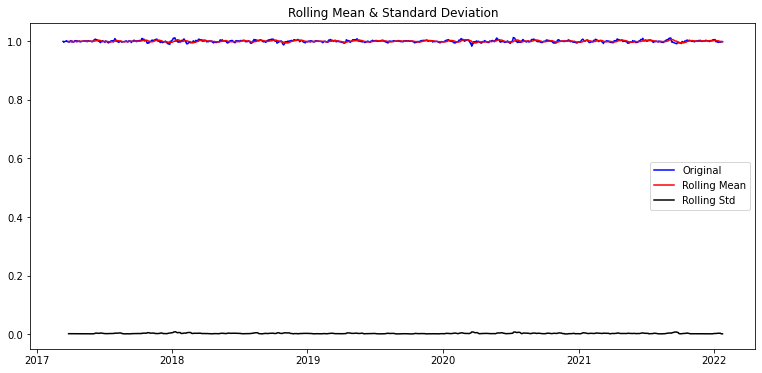

In [67]:
# Residual 안정성 확인
plot_rolling_statistics(residual)

In [68]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.061921e+01
p-value                        5.571568e-19
#Lags Used                     2.300000e+01
Number of Observations Used    1.171000e+03
Critical Value (1%)           -3.435947e+00
Critical Value (5%)           -2.864011e+00
Critical Value (10%)          -2.568086e+00
dtype: float64


#### 4)  학습, 테스트 데이터셋 생성

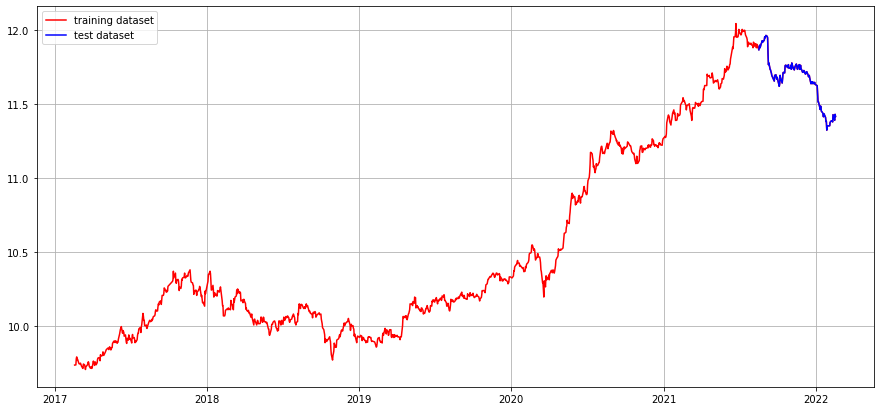

In [69]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(15,7))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [70]:
print(train_data.shape)
print(test_data.shape)

(1102,)
(123,)


#### 5) 적정 ARIMA 모수 찾기

<Figure size 720x432 with 0 Axes>

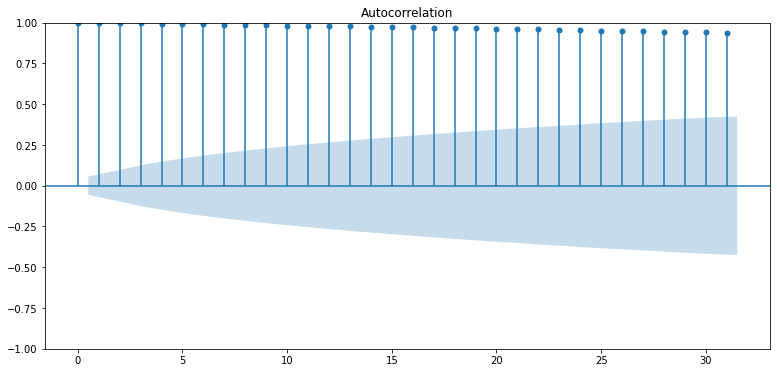

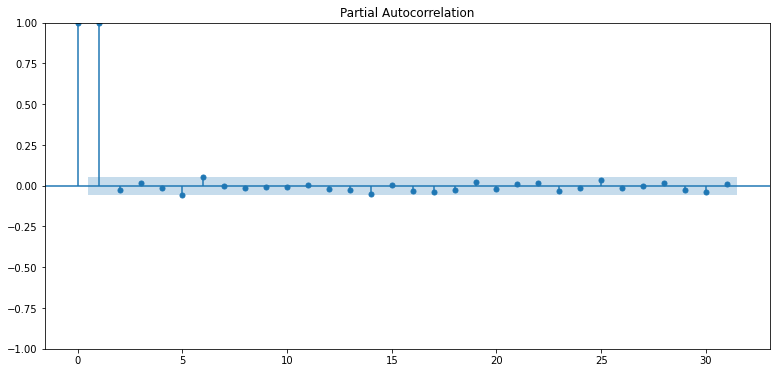

In [71]:
# ACF, PACF 그려보기 -> p,q 구하기
plt.figure(figsize=(10,6))
plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

역시 ACF는 아주 조금씩 감소하고 있고, PACF는 시차 1 이후에 0이 되므로 역시 AR(1) 모델에 유사하고 MA랑은 맞지 않으므로 p=1, q=0으로 지정해준다.

Results of Dickey-Fuller Test:
Test Statistic                  -22.836100
p-value                           0.000000
#Lags Used                        1.000000
Number of Observations Used    1222.000000
Critical Value (1%)              -3.435713
Critical Value (5%)              -2.863908
Critical Value (10%)             -2.568031
dtype: float64


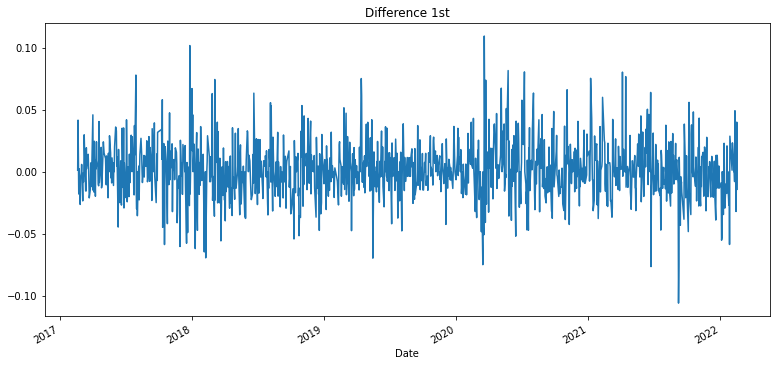

In [72]:
# 차분 안정성 확인
# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

1차 차분을 해줬을 때 p-value가 완전히 0이 되므로 차분을 안해줘도 될 것 같다. d=0으로 지정해보겠다.

#### 6) ARIMA 모델 훈련과 테스트

In [73]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(1, 0, 0))   # p=1, d=0, q=0
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1102
Model:                 ARIMA(1, 0, 0)   Log Likelihood                2607.307
Date:                Thu, 17 Feb 2022   AIC                          -5208.614
Time:                        14:22:12   BIC                          -5193.599
Sample:                             0   HQIC                         -5202.934
                               - 1102                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.5875      1.367      7.745      0.000       7.908      13.267
ar.L1          0.9998      0.001    977.328      0.000       0.998       1.002
sigma2         0.0005   1.57e-05     32.552      0.0

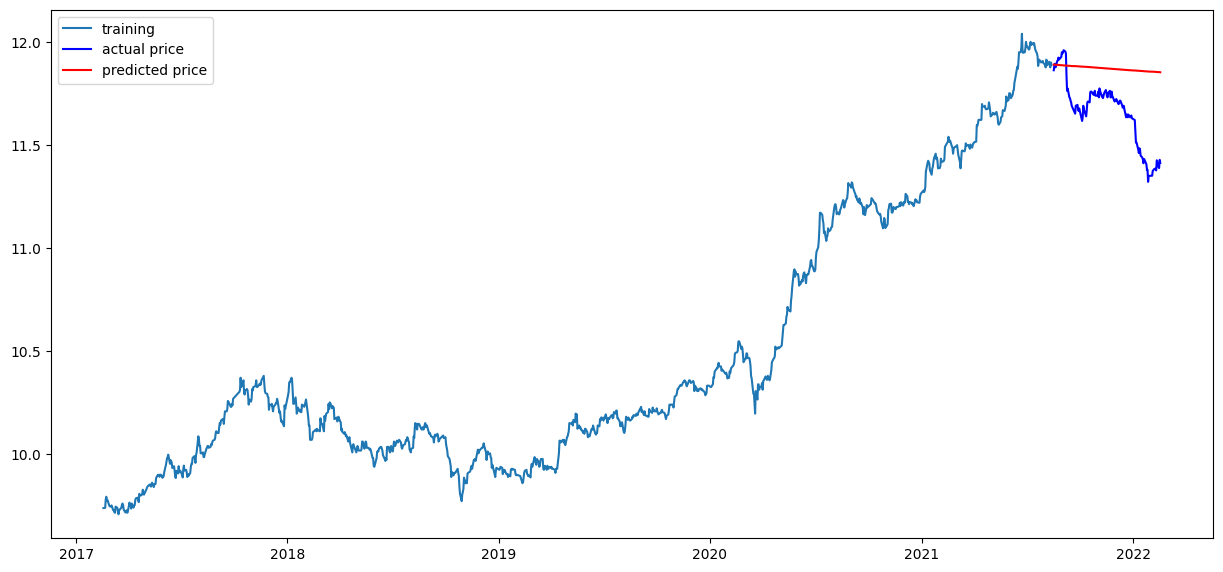

In [74]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담김
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(15,7), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [75]:
# 최종 예측 모델 정확도 측정(MAPE)
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  909423721.7507269
MAE:  26179.14890392975
RMSE:  30156.653026334454
MAPE: 24.81%


하.. 구글링 아무리 해봐도 p, d, q 어떻게 구하는건지 모르겠다.
<br> p의 값을 lms 실습예시의 14에서 힌트를 얻어서 나도 27~30을 넣어보겠다.

In [76]:
# ARIMA 모델 빌드와 훈련
model = ARIMA(train_data, order=(27, 0, 0))   # p=27, d=0, q=0
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1102
Model:                ARIMA(27, 0, 0)   Log Likelihood                2418.681
Date:                Thu, 17 Feb 2022   AIC                          -4779.362
Time:                        14:23:44   BIC                          -4634.221
Sample:                             0   HQIC                         -4724.459
                               - 1102                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.6013      0.104    101.634      0.000      10.397      10.806
ar.L1          0.5692      0.034     16.944      0.000       0.503       0.635
ar.L2          0.7522      0.049     15.292      0.0

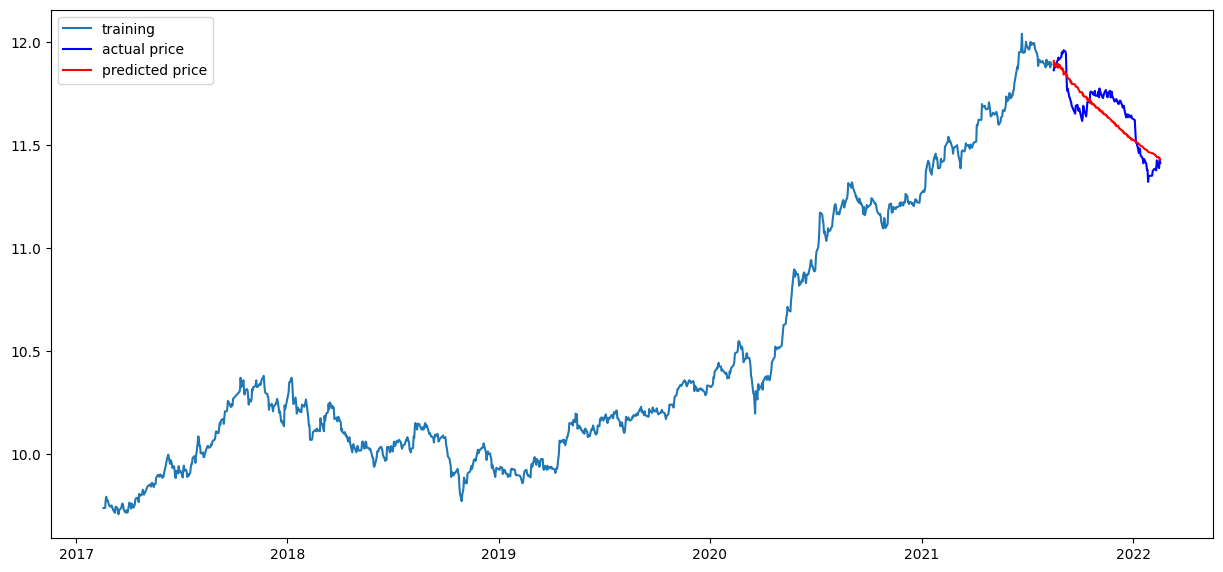

In [77]:
# 모델 테스트 및 플로팅

# Forecast : 결과가 fc에 담김
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(15,7), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [78]:
# 최종 예측 모델 정확도 측정(MAPE)
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  102160235.53341879
MAE:  9064.582154104963
RMSE:  10107.434666294845
MAPE: 7.67%


7%대의 MAPE이 나오고 예측 그래프의 방향도 얼추 맞는다.
일단 세 종목 모두 15% 이하의 MAPE를 도출해내는 것은 성공했다. 그러나 그래프 상에서 제대로 예측을 하지 못한 것 같아서 매우 찝찝하다.

---
**<번외>**
<br>구글링을 열심히 해보니 pmdarima 패키지의 auto_arima 모듈이 최적의 모수값을 찾아주는 역할을 한다고 해서, 찾아서 돌려봤다.

In [79]:
from pmdarima.arima import auto_arima

model_arima= auto_arima(train_data,trace=True, error_action='ignore', start_p=0,start_q=0,max_p=30,max_q=30,suppress_warnings=True,stepwise=False,seasonal=True)

model_arima.fit(train_data)

 ARIMA(0,1,0)(0,0,0)[1] intercept   : AIC=-5221.694, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[1] intercept   : AIC=-5219.754, Time=0.12 sec
 ARIMA(0,1,2)(0,0,0)[1] intercept   : AIC=-5226.278, Time=0.24 sec
 ARIMA(0,1,3)(0,0,0)[1] intercept   : AIC=-5224.289, Time=0.76 sec
 ARIMA(0,1,4)(0,0,0)[1] intercept   : AIC=-5222.679, Time=1.10 sec
 ARIMA(0,1,5)(0,0,0)[1] intercept   : AIC=-5221.677, Time=3.54 sec
 ARIMA(1,1,0)(0,0,0)[1] intercept   : AIC=-5219.765, Time=0.23 sec
 ARIMA(1,1,1)(0,0,0)[1] intercept   : AIC=-5217.853, Time=0.12 sec
 ARIMA(1,1,2)(0,0,0)[1] intercept   : AIC=-5224.284, Time=0.47 sec
 ARIMA(1,1,3)(0,0,0)[1] intercept   : AIC=-5222.288, Time=0.84 sec
 ARIMA(1,1,4)(0,0,0)[1] intercept   : AIC=-5220.296, Time=0.54 sec
 ARIMA(2,1,0)(0,0,0)[1] intercept   : AIC=-5226.438, Time=0.24 sec
 ARIMA(2,1,1)(0,0,0)[1] intercept   : AIC=-5224.496, Time=0.19 sec
 ARIMA(2,1,2)(0,0,0)[1] intercept   : AIC=-5222.485, Time=0.44 sec
 ARIMA(2,1,3)(0,0,0)[1] intercept   : AIC=-5220.291, Time=1.52

ARIMA(order=(2, 1, 0), scoring_args={}, seasonal_order=(0, 0, 0, 1),
      suppress_warnings=True)

p=2, d=1, q=0이 베스트라고 하니 넣어봐야겠다.

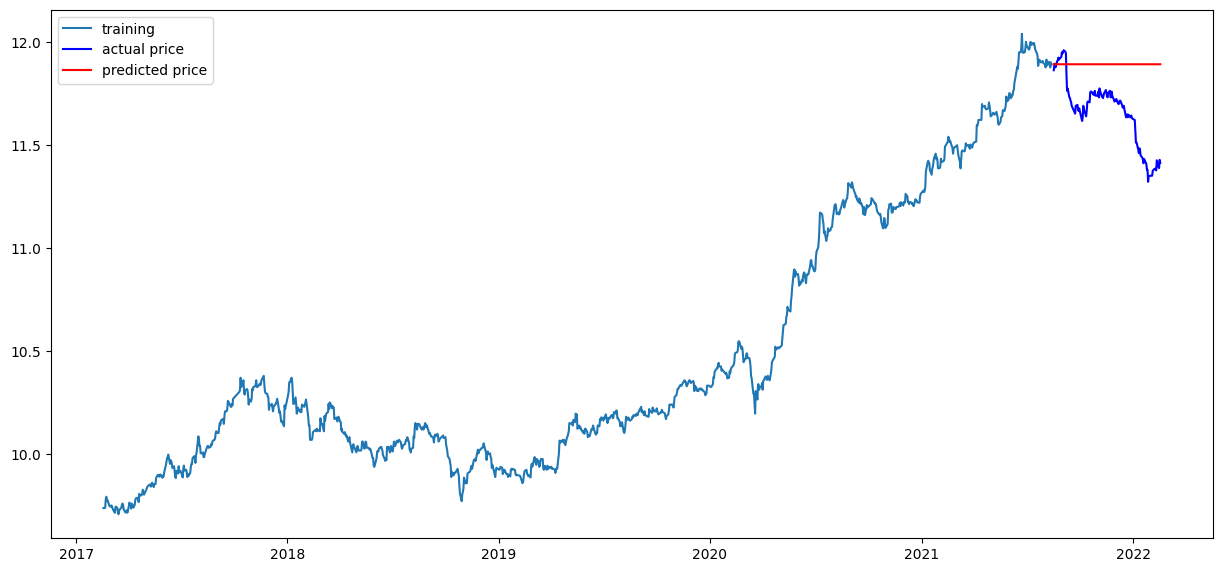

In [80]:
model = ARIMA(train_data, order=(2, 1, 0))   # p=2, d=1, q=0
fitted_m = model.fit() 

# Forecast : 결과가 fc에 담김
fc= fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(15,7), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

내가 완벽하게 개념을 이해를 못해서 모듈도 활용을 못하는 것 같다.
주식 예측은 여기서 끝내겠다.

---

# 회고

이번 노드는 시계열 데이터로 예측 모델을 만드는 것이라 꽤 재밌을 것 같아서 기대를 했다. 그런데 막상 해보니 제대로 예측하는 것도 불가능하고 무엇보다도 통계에 대해 지식이 너무 부족해서, ARIMA 모델을 이해하는 데에도 너무 오랜 시간이 걸렸고, ARIMA의 모수를 뽑아내는 것도 결국 이해를 실패했다. 개념적으로 어떻게 해야하는지 알았고 분명히 시키는대로 뽑았는데, 예측도 제대로 안되고 계속 이상했다. 통계에 대해서 좀 더 확실히 공부하고 나서 이 프로젝트를 다시 해봐야겠다.

날씨 데이터나 비트코인 가격 데이터에 대해서도 시행해보고 싶었는데, ARIMA에 대해 더 공부한 뒤에 해야겠다 싶어서 다음 기회로 미뤘다.